# Cycle GAN


Jedan od najvećih problema pix2pix metode je što zahteva da se skupovi podataka upareni. Takvih skupova je vrlo malo, dok neuparenih imamo daleko više. CycleGAN nam nudi metodu da prevaziđemo ovaj problem. Naime ideja je da možemo da nučimo preslikavanje iz jednog skupa slika u drugi bez obzira da li oni imaju neke vidljive sličnosti. Naravno u zavisnosti od kvaliteta skupa podataka zavisiće i šta je naučio model.
Sledeća slika predstavlja razliku izmedju uparenih skupova podataka i neuparenih.


<img src="images/paired.png"  width="500" hight="500" align="left">

Ideja je da ako imamo dva skupa podataka X i Y da uzmemo dva generatora, prvi koji će preskikavati X u Y, dok će drugi raditi obrnuto, tj. preslikavati Y u X. Neka je x instanca skupa X i neka G slika X u Y, dok F slika Y u X. Želja nam je da se
F(G(x)) ne razlikuje previše od instance x. Greška koja se odnosi na kompoziciju preslikavanja F(G(x)) i inverznog preslikavanja G naziva se **ciklična greška**. 
Kako su nam potrebna dva generatora, tako će nam biti potrebna i dva diskriminatora, jedan će klasifikovati da li je slika iz skupa Y stvarna ili generisana, dok će drugi to isto raditi samo za skup X.

**Greška identiteta** se dobija kada se preslikavanje G primeni na skup Y. Želimo isto se generisane slike u ovom slučaju što manje razlikuju od svojih ulaznih slika. Isto tako možemo definisati grešku identiteta za preslikavanje F i skup X.
<img src="images/cycle-gan-model.png"  width="950" hight="650" align="left">


Pokušaćemo da primenimo metodu Cycle Gan na dva generisana skupa, na fashion-mnist i na invertovane slike iz istog tog skupa.

In [73]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import time
import datetime
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython import display
import torch
from IPython.display import clear_output
AUTOTUNE = tf.data.AUTOTUNE

In [27]:
(train_images,_), (test_images,_) = tf.keras.datasets.fashion_mnist.load_data()

In [28]:
assert train_images.shape == (60000, 28, 28)
assert test_images.shape == (10000,28,28) 

In [29]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 

In [30]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5 

In [31]:
BUFFER_SIZE = 200
BATCH_SIZE = 1
train_images.shape

(60000, 28, 28, 1)

Invertujemo boje na slikama iz skupa, tj. možimo sve tensore sa -1.

In [32]:
train_images_inverted = -1*train_images

In [33]:
train_images_inverted.shape

(60000, 28, 28, 1)

In [34]:
IMG_HEIGHT = 28
IMG_WIDTH = 28

In [35]:
# dodavanje random isecanja da bismo dodali šum u podatke
def random_crop(image):
    cropped_image = tf.image.random_crop(
          image, size=[IMG_HEIGHT, IMG_WIDTH, 1])

    return cropped_image

In [37]:
def random_jitter(image):
    
    image = tf.image.resize(image, [32, 32],
                          method="nearest")

  
    image = random_crop(image)

  # osna simetrija slike
    image = tf.image.random_flip_left_right(image)

    return image

In [38]:
original_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [39]:
inverted_dataset = tf.data.Dataset.from_tensor_slices(train_images_inverted).map(random_jitter,num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Prikaz slike iz originalnog skupa

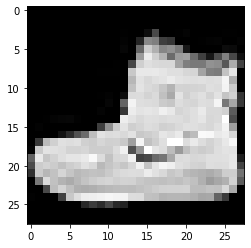

In [40]:
plt.imshow(train_images[0], cmap=plt.get_cmap('gray'))

Prikaz slike iz generisanog skupa, tj. kad su slike invertovane.

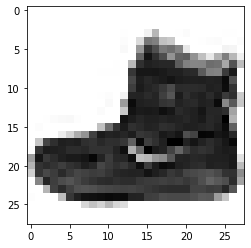

In [43]:
plt.imshow(train_images_inverted[0], cmap=plt.get_cmap('gray'))

In [44]:
original_sample = next(iter(original_dataset))
inverted_sample = next(iter(inverted_dataset))

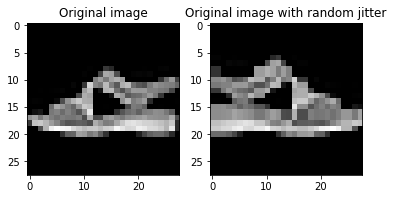

In [45]:
plt.subplot(121)
plt.title('Original image')
plt.imshow(original_sample[0] * 0.5 + 0.5,cmap='gray')

plt.subplot(122)
plt.title('Original image with random jitter')
plt.imshow(random_jitter(original_sample[0]) * 0.5 + 0.5,cmap='gray')

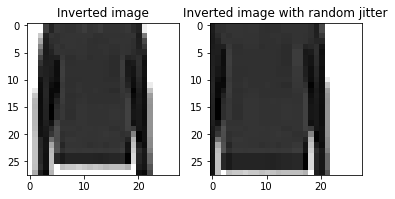

In [46]:
plt.subplot(121)
plt.title('Inverted image')
plt.imshow(inverted_sample[0] * 0.5 + 0.5,cmap='gray')

plt.subplot(122)
plt.title('Inverted image with random jitter')
plt.imshow(random_jitter(inverted_sample[0]) * 0.5 + 0.5,cmap='gray')

In [47]:
def Generator():
    
    initializer = tf.random_normal_initializer(0.,0.12)
    inputs = tf.keras.layers.Input(shape=[28,28,1])
    
    conv2d_1 = tf.keras.layers.Conv2D(16,3,strides=2,kernel_initializer=initializer,padding='same')(inputs)
    conv2d_2 = tf.keras.layers.Conv2D(16,3,strides=2,kernel_initializer=initializer,padding='same')(conv2d_1)
    conv2dT = tf.keras.layers.Conv2DTranspose(16,3,strides=2,kernel_initializer=initializer,padding='same')(conv2d_2)
    tmp = tf.keras.layers.Concatenate()([conv2d_1,conv2dT])
    
    last = tf.keras.layers.Conv2DTranspose(1,4,strides=2,kernel_initializer=initializer,padding='same',activation='tanh')(tmp)
    
    return tf.keras.Model(inputs=inputs,outputs=last)

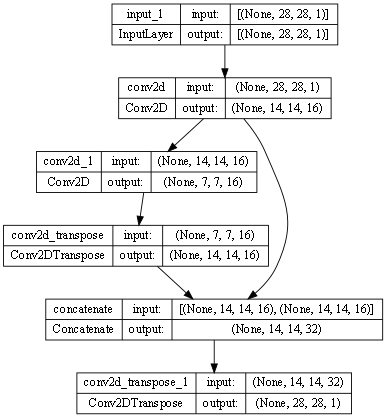

In [48]:
generator = Generator()
tf.keras.utils.plot_model(generator,to_file="./models/03-cyclegan/generator.png",show_shapes=True,dpi=64)

In [49]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 16)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 16)     2320        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 14, 14, 16)  2320        ['conv2d_1[0][0]']               
 ose)                                                                                         

In [50]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.12)
    
    inp = tf.keras.layers.Input(shape=[28,28,1],name="input_image")
    
    
    
    
    layer1 = tf.keras.layers.Conv2D(16,4,strides=2,padding='same',
                              kernel_initializer=initializer,use_bias=False)(inp)
    layer2 = tf.keras.layers.Conv2D(16,4,strides=2,padding='same',
                              kernel_initializer=initializer,use_bias=False)(layer1)
    last  = tf.keras.layers.Conv2D(1,4,strides=1)(layer2)
    
    return tf.keras.Model(inputs=inp,outputs=last)

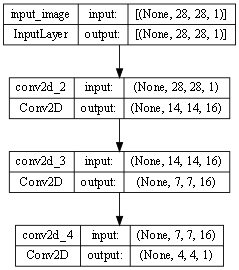

In [51]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator,to_file="./models/03-cyclegan/diskriminator.png",show_shapes=True,dpi=64)

In [52]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        256       
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 16)          4096      
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 1)           257       
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


Kreiramo dva generatora i dva diskriminatora. Generator g ce spreslikavati invertovane slike u originalne, dok će generator f raditi suprotno. Diskriminator x je zadužen da klasifikuje da li generisana slika pripada originalnom skupu, dok diskriminator radi to za invertovani skup.

In [53]:
generator_g = Generator()
generator_f = Generator()

discriminator_x = Discriminator()
discriminator_y = Discriminator()

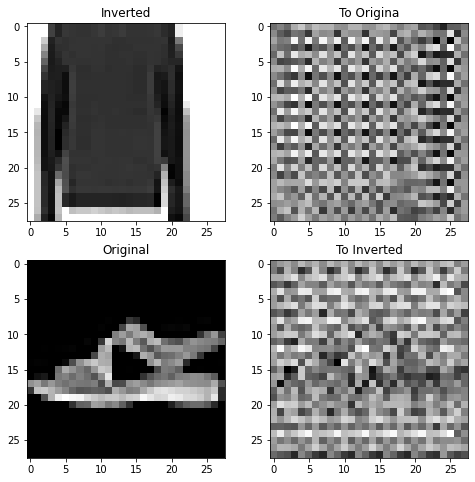

In [55]:
to_original = generator_g(inverted_sample)
to_inverted = generator_f(original_sample)
plt.figure(figsize=(8,8))

contrast = 8

imgs = [inverted_sample, to_original, original_sample, to_inverted]
title = ['Inverted', 'To Origina', 'Original', 'To Inverted']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5,cmap='gray')
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5,cmap='gray')
plt.show()

In [58]:
LAMBDA =10

In [59]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

O funkcijama gubitka biće više reči u poslednjoj radnoj svesci 05-cyclegan-winter2summer.

In [61]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [62]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [63]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [64]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [65]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [66]:
checkpoint_path = "./checkpoints/03-cycle-gan/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Ucitano poslednji sacuvani checkpoint')

In [74]:
EPOCHS = 2

In [68]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5,cmap='gray')
        plt.axis('off')
    plt.show()

In [69]:
@tf.function
def train_step(real_x, real_y):

    with tf.GradientTape(persistent=True) as tape:
        # Generator G mapira X -> Y
        # Generator F mapira Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y za funkciju gubitka identieta.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # racunjanje gubitka
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Racunajnje ukupne greske generatora
        id_loss_gen_g = identity_loss(real_y, same_y)
        
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Racunanje gradijenata
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    
    return total_gen_g_loss, gen_g_loss, id_loss_gen_g , disc_x_loss, total_cycle_loss

In [70]:
total_gen_g_loss_list = []
gen_g_loss_list = []
id_loss_gen_g_list = []
disc_x_loss_list_list= []
total_cycle_loss_list = []

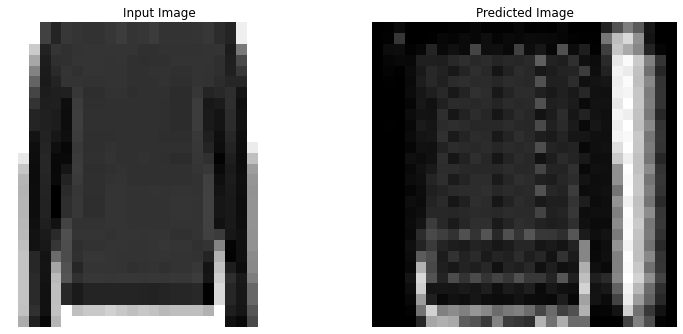

Time taken for epoch 2 is 696.906054019928 sec



In [76]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((inverted_dataset, original_dataset)):
        total_gen_g_loss, gen_g_loss, id_loss_gen_g , disc_x_loss, total_cycle_loss = train_step(image_x, image_y)
        if n % 100 == 0:
            print ('.', end='')
            gen_g_loss_list.append(gen_g_loss)
            total_gen_g_loss_list.append(total_gen_g_loss)
            id_loss_gen_g_list.append(id_loss_gen_g)
            disc_x_loss_list_list.append(disc_x_loss)
            total_cycle_loss_list.append(total_cycle_loss)
            
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g,inverted_sample )

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

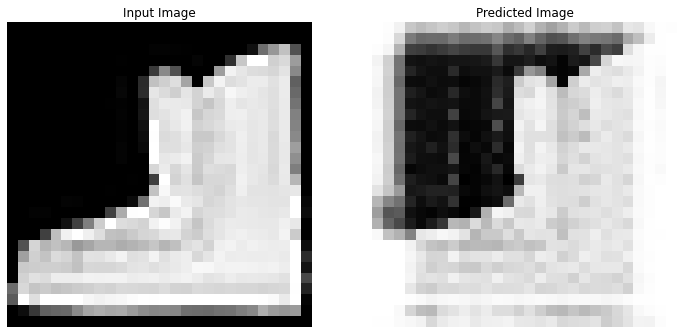

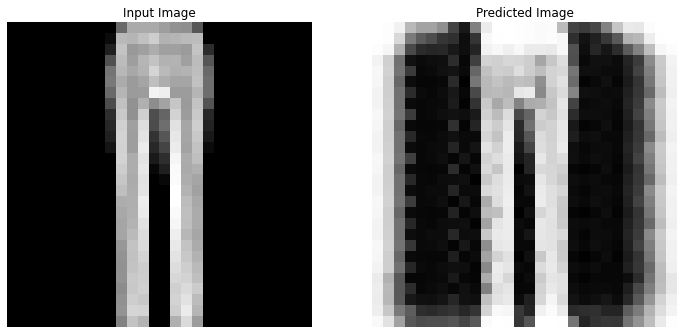

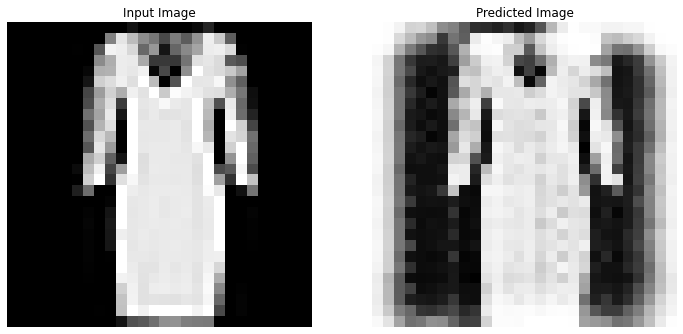

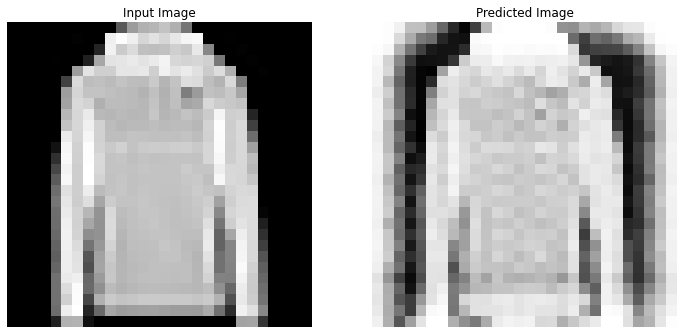

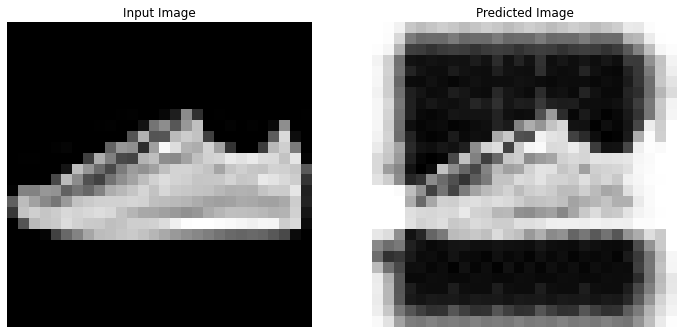

In [78]:
# prebacivanje slika zime u leto
for sample in original_dataset.take(5):
    generate_images(generator_f, sample)

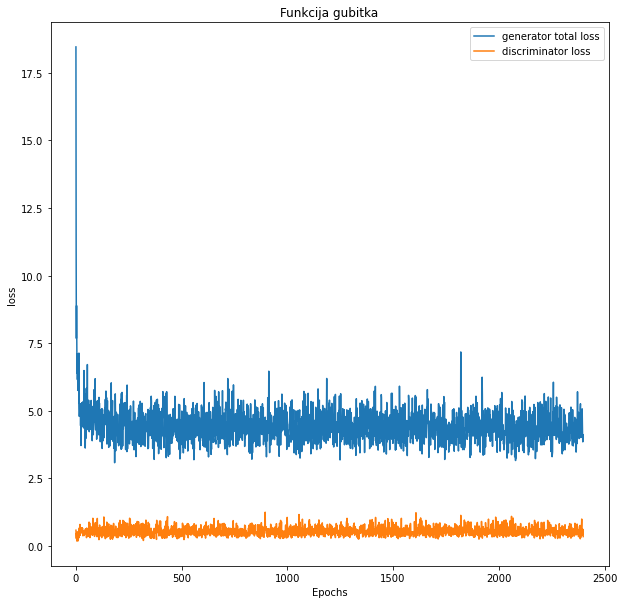

In [79]:
plt.figure(figsize=(10,10))
plt.title('Funkcija gubitka')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(np.arange(0,len(total_gen_g_loss_list)), total_gen_g_loss_list, label='generator total loss')
plt.plot(np.arange(0,len(disc_x_loss_list_list)), disc_x_loss_list_list, label='discriminator loss')
plt.legend(loc='best')
plt.show()

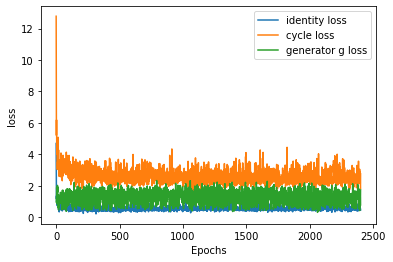

In [80]:
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(np.arange(0,len(id_loss_gen_g_list)), id_loss_gen_g_list, label='identity loss')
plt.plot(np.arange(0,len(total_cycle_loss_list)), total_cycle_loss_list, label='cycle loss')
plt.plot(np.arange(0,len(gen_g_loss_list)), gen_g_loss_list, label='generator g loss')
plt.legend(loc='best')
plt.show()